#### Pandas Part 69: Advanced DataFrame Operations

This notebook covers various advanced DataFrame operations including reshaping, combining/joining/merging, time series operations, and kernel density estimation (KDE) plotting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

##### 1. Reshaping and Pivot Operations

Pandas provides several methods to reshape DataFrames:

In [2]:
# Create a sample DataFrame with MultiIndex
arrays = [
    ['A', 'A', 'B', 'B'],
    [1, 2, 1, 2]
]
index = pd.MultiIndex.from_arrays(arrays, names=('first', 'second'))
df = pd.DataFrame({'value': [1, 2, 3, 4]}, index=index)
df

value
first second       
A     1           1
      2           2
B     1           3
      2           4

### Stack and Unstack

Stack moves data from columns to index levels, while unstack does the opposite.

In [3]:
# Create a simple DataFrame
df2 = pd.DataFrame({
    'A': ['a', 'b', 'a', 'b'],
    'B': [1, 2, 3, 4],
    'C': [10, 20, 30, 40]
})
df2

,A,B,C
0,a,1,10
1,b,2,20
2,a,3,30
3,b,4,40


In [4]:
# Set 'A' as index
df2_indexed = df2.set_index('A')
df2_indexed

,B,C
A,,
a,1,10
b,2,20
a,3,30
b,4,40


In [5]:
# Stack the DataFrame
stacked = df2_indexed.stack()
stacked

A   
a  B     1
   C    10
b  B     2
   C    20
a  B     3
   C    30
b  B     4
   C    40
dtype: int64

In [7]:
# Option 1: Drop duplicates before unstacking
unique_stacked = stacked[~stacked.index.duplicated()]
unstacked = unique_stacked.unstack()
print("Unstacked after dropping duplicates:")
print(unstacked)

# Option 2: Aggregate duplicates using a function
aggregated_stacked = stacked.groupby(level=[0, 1]).first()  # or .sum(), .mean(), etc.
unstacked = aggregated_stacked.unstack()
print("\nUnstacked after aggregating duplicates:")
print(unstacked)

Unstacked after dropping duplicates:
   B   C
A       
a  1  10
b  2  20

Unstacked after aggregating duplicates:
   B   C
A       
a  1  10
b  2  20


### Melt

Melt transforms a DataFrame from wide to long format.

In [8]:
# Create a wide format DataFrame
wide_df = pd.DataFrame({
    'name': ['John', 'Mary', 'Bob'],
    'math': [90, 85, 92],
    'science': [88, 95, 85],
    'history': [76, 82, 89]
})
wide_df

,name,math,science,history
0,John,90,88,76
1,Mary,85,95,82
2,Bob,92,85,89


In [9]:
# Melt the DataFrame to long format
melted_df = wide_df.melt(id_vars=['name'], value_vars=['math', 'science', 'history'],
                         var_name='subject', value_name='score')
melted_df

,name,subject,score
0,John,math,90
1,Mary,math,85
2,Bob,math,92
3,John,science,88
4,Mary,science,95
5,Bob,science,85
6,John,history,76
7,Mary,history,82
8,Bob,history,89


### Explode

Explode transforms each element of a list-like to a row.

In [10]:
# Create a DataFrame with list values
df_list = pd.DataFrame({
    'A': [[1, 2, 3], [4, 5], [6]],
    'B': 1
})
df_list

,A,B
0,"[1, 2, 3]",1
1,"[4, 5]",1
2,[6],1


In [11]:
# Explode column A
df_list.explode('A')

,A,B
0,1,1
0,2,1
0,3,1
1,4,1
1,5,1
2,6,1


##### 2. Combining/Joining/Merging

Pandas provides several methods to combine DataFrames:

In [12]:
# Create two sample DataFrames
df1 = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'name': ['Alice', 'Bob', 'Charlie', 'David']
})

df2 = pd.DataFrame({
    'id': [1, 2, 3, 5],
    'salary': [50000, 60000, 70000, 80000]
})

print("DataFrame 1:")
print(df1)
print("\nDataFrame 2:")
print(df2)

DataFrame 1:
   id     name
0   1    Alice
1   2      Bob
2   3  Charlie
3   4    David

DataFrame 2:
   id  salary
0   1   50000
1   2   60000
2   3   70000
3   5   80000


### Merge

Merge combines DataFrames based on common columns or indices.

In [13]:
# Inner merge
pd.merge(df1, df2, on='id', how='inner')

,id,name,salary
0,1,Alice,50000
1,2,Bob,60000
2,3,Charlie,70000


In [14]:
# Left merge
pd.merge(df1, df2, on='id', how='left')

,id,name,salary
0,1,Alice,50000.0
1,2,Bob,60000.0
2,3,Charlie,70000.0
3,4,David,NaN


In [15]:
# Right merge
pd.merge(df1, df2, on='id', how='right')

,id,name,salary
0,1,Alice,50000
1,2,Bob,60000
2,3,Charlie,70000
3,5,NaN,80000


In [16]:
# Outer merge
pd.merge(df1, df2, on='id', how='outer')

,id,name,salary
0,1,Alice,50000.0
1,2,Bob,60000.0
2,3,Charlie,70000.0
3,4,David,NaN
4,5,NaN,80000.0


### Join

Join combines columns from another DataFrame.

In [17]:
# Set index for both DataFrames
df1_indexed = df1.set_index('id')
df2_indexed = df2.set_index('id')

# Join the DataFrames
df1_indexed.join(df2_indexed)

,name,salary
id,,
1,Alice,50000.0
2,Bob,60000.0
3,Charlie,70000.0
4,David,NaN


### Append

Append adds rows from another DataFrame.

In [19]:
# Create two DataFrames with the same columns
df_a = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})
df_b = pd.DataFrame({'A': [5, 6], 'B': [7, 8]})

# Append df_b to df_a
pd.concat([df_a, df_b])

,A,B
0,1,3
1,2,4
0,5,7
1,6,8


##### 3. Time Series Operations

Pandas provides several methods for time series data:

In [20]:
# Create a time series DataFrame
dates = pd.date_range('2023-01-01', periods=6)
ts_df = pd.DataFrame(np.random.randn(6, 4), index=dates, columns=list('ABCD'))
ts_df

,A,B,C,D
2023-01-01,1.084000,0.220121,-2.971162,0.398465
2023-01-02,0.443139,0.828168,0.619600,-0.053466
2023-01-03,0.145262,1.108522,-1.010418,-1.303024
2023-01-04,1.095310,2.174520,-1.052226,-0.069599
2023-01-05,-0.918027,0.625269,0.010375,-1.188160
2023-01-06,-0.510879,1.137551,-0.834617,1.529762


### Shift

Shift moves data forward or backward by a specified number of periods.

In [21]:
# Shift data forward by 2 periods
ts_df.shift(2)

,A,B,C,D
2023-01-01,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN
2023-01-03,1.084000,0.220121,-2.971162,0.398465
2023-01-04,0.443139,0.828168,0.619600,-0.053466
2023-01-05,0.145262,1.108522,-1.010418,-1.303024
2023-01-06,1.095310,2.174520,-1.052226,-0.069599


In [22]:
# Shift data backward by 1 period
ts_df.shift(-1)

,A,B,C,D
2023-01-01,0.443139,0.828168,0.619600,-0.053466
2023-01-02,0.145262,1.108522,-1.010418,-1.303024
2023-01-03,1.095310,2.174520,-1.052226,-0.069599
2023-01-04,-0.918027,0.625269,0.010375,-1.188160
2023-01-05,-0.510879,1.137551,-0.834617,1.529762
2023-01-06,NaN,NaN,NaN,NaN


### Resample

Resample changes the frequency of time series data.

In [23]:
# Resample to 2-day frequency
ts_df.resample('2D').mean()

,A,B,C,D
2023-01-01,0.763569,0.524144,-1.175781,0.172499
2023-01-03,0.620286,1.641521,-1.031322,-0.686311
2023-01-05,-0.714453,0.881410,-0.412121,0.170801


In [24]:
# Resample to month-end frequency
ts_df.resample('M').sum()

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_88206/3891326402.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_df.resample('M').sum()


,A,B,C,D
2023-01-31,1.338804,6.09415,-5.238449,-0.686022


### asfreq

asfreq converts a time series to a specified frequency.

In [25]:
# Convert to business day frequency
ts_df.asfreq('B')

,A,B,C,D
2023-01-02,0.443139,0.828168,0.619600,-0.053466
2023-01-03,0.145262,1.108522,-1.010418,-1.303024
2023-01-04,1.095310,2.174520,-1.052226,-0.069599
2023-01-05,-0.918027,0.625269,0.010375,-1.188160
2023-01-06,-0.510879,1.137551,-0.834617,1.529762


##### 4. Kernel Density Estimation (KDE) Plotting

KDE is a non-parametric way to estimate the probability density function of a random variable.

In [26]:
# Create a Series for KDE plotting
s = pd.Series([1, 2, 2.5, 3, 3.5, 4, 5])
s

0    1.0
1    2.0
2    2.5
3    3.0
4    3.5
5    4.0
6    5.0
dtype: float64

Text(0.5, 1.0, 'KDE Plot with Default Bandwidth')

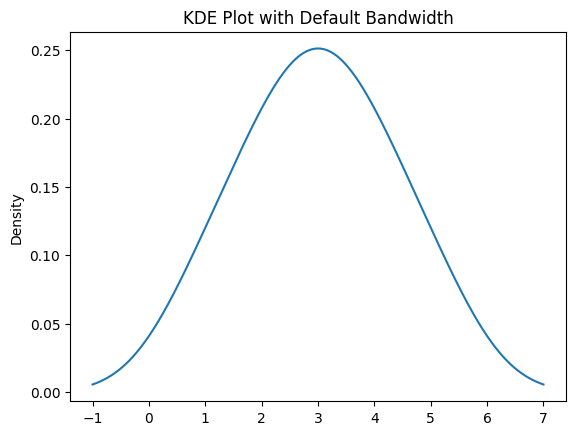

In [27]:
# Plot KDE with default settings
ax = s.plot.kde()
plt.title('KDE Plot with Default Bandwidth')

Text(0.5, 1.0, 'KDE Plot with Small Bandwidth (0.3)')

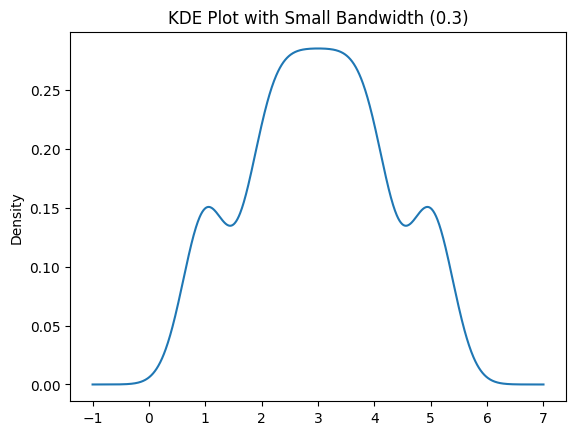

In [28]:
# Plot KDE with small bandwidth (potential over-fitting)
ax = s.plot.kde(bw_method=0.3)
plt.title('KDE Plot with Small Bandwidth (0.3)')

Text(0.5, 1.0, 'KDE Plot with Large Bandwidth (3)')

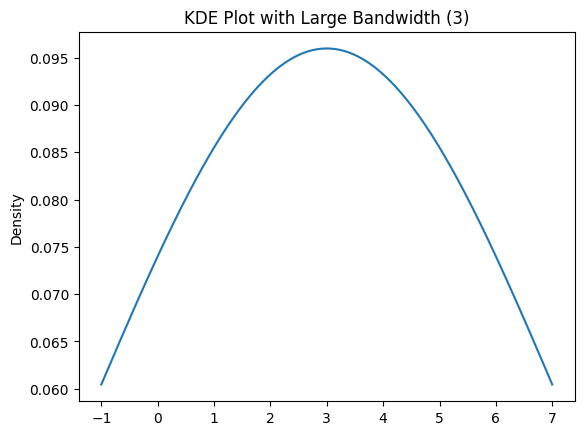

In [29]:
# Plot KDE with large bandwidth (potential under-fitting)
ax = s.plot.kde(bw_method=3)
plt.title('KDE Plot with Large Bandwidth (3)')

Text(0.5, 1.0, 'KDE Plot with Specific Evaluation Points')

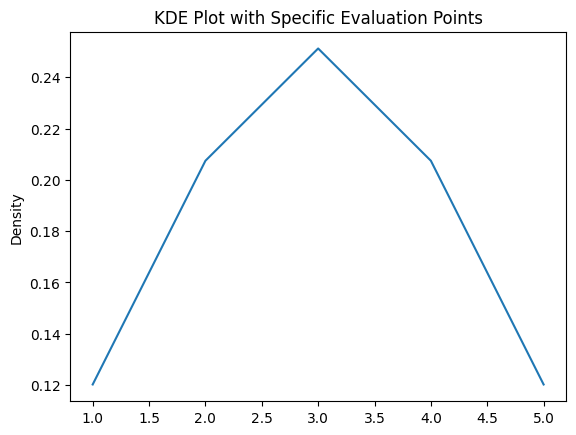

In [30]:
# Plot KDE with specific evaluation points
ax = s.plot.kde(ind=[1, 2, 3, 4, 5])
plt.title('KDE Plot with Specific Evaluation Points')

### KDE with DataFrame

In [31]:
# Create a DataFrame for KDE plotting
df_kde = pd.DataFrame({
    'x': [1, 2, 2.5, 3, 3.5, 4, 5],
    'y': [4, 4, 4.5, 5, 5.5, 6, 6],
})
df_kde

,x,y
0,1.0,4.0
1,2.0,4.0
2,2.5,4.5
3,3.0,5.0
4,3.5,5.5
5,4.0,6.0
6,5.0,6.0


Text(0.5, 1.0, 'KDE Plot for DataFrame with Default Bandwidth')

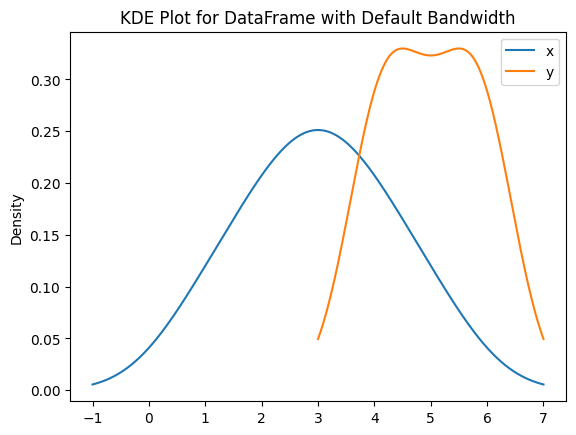

In [32]:
# Plot KDE for DataFrame with default settings
ax = df_kde.plot.kde()
plt.title('KDE Plot for DataFrame with Default Bandwidth')

Text(0.5, 1.0, 'KDE Plot for DataFrame with Small Bandwidth (0.3)')

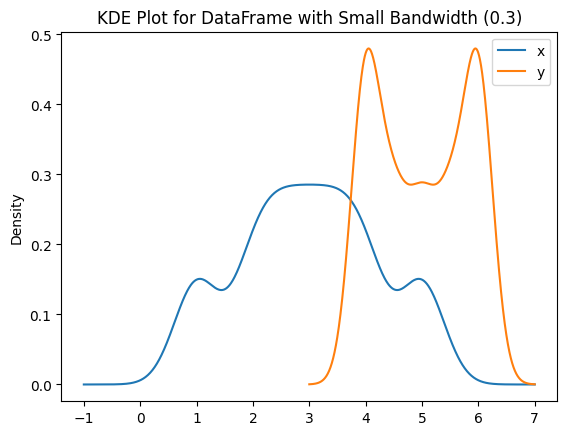

In [33]:
# Plot KDE for DataFrame with small bandwidth
ax = df_kde.plot.kde(bw_method=0.3)
plt.title('KDE Plot for DataFrame with Small Bandwidth (0.3)')

Text(0.5, 1.0, 'KDE Plot for DataFrame with Large Bandwidth (3)')

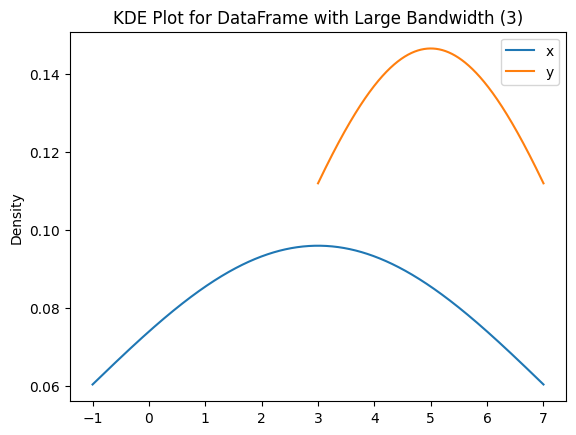

In [34]:
# Plot KDE for DataFrame with large bandwidth
ax = df_kde.plot.kde(bw_method=3)
plt.title('KDE Plot for DataFrame with Large Bandwidth (3)')

Text(0.5, 1.0, 'KDE Plot for DataFrame with Specific Evaluation Points')

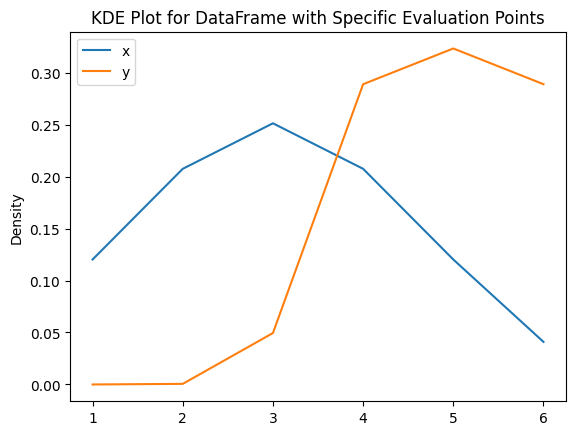

In [35]:
# Plot KDE for DataFrame with specific evaluation points
ax = df_kde.plot.kde(ind=[1, 2, 3, 4, 5, 6])
plt.title('KDE Plot for DataFrame with Specific Evaluation Points')